In [10]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import pyspark.sql.functions as f

from itertools import chain
import pandas as pd
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [11]:
DB_USER = 'root'
DB_PASS = 'root'
DB_NAME = 'telco_churn'
HOST = 'localhost:3306'

In [12]:
spark = SparkSession.builder.getOrCreate()

In [13]:
spark

# Import Data

In [18]:
status_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "status",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [19]:
status_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)



In [20]:
demographic_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "demographics",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [21]:
demographic_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)



In [22]:
service_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "services",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [23]:
service_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Avg Monthly GB Download: integer (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection Plan: string (nullable = true)
 |-- Premium Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Streaming Music: string (nullable = true)
 |-- Unlimited Data: string (nullable = true)


In [24]:
df = status_df.join(demographic_df, "Customer ID").join(service_df, "Customer ID")

In [25]:
df = df.filter(df['Under 30'] == 'Yes')

In [26]:
print(f"Number of columns: {len(df.columns)}")
df.printSchema()

Number of columns: 48
root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (null

# Utils

In [27]:
# remove duplicate columns
def remove_duplicate_columns(df):
    print(f"Initial Number of Columns: {len(df.columns)}")
    df_cols = df.columns
    existed = []
    duplicate_col_index = []
    idx = 0
    for c in df_cols:
        if c in existed:
            duplicate_col_index.append(idx)
        else:
            existed.append(c)
        idx = idx + 1

    for i in duplicate_col_index:
        df_cols[i] = df_cols[i] + '_duplicated'

    df = df.toDF(*df_cols)
    cols_to_remove = [c for c in df_cols if '_duplicated' in c]
    df = df.drop(*cols_to_remove)

    print("\nDuplicated columns removed from the dataframe:")
    print([df_cols[i] for i in duplicate_col_index])
    print(f"\nFinal Number of Columns: {len(df.columns)}")
    return df

In [28]:
def features_selection(df):
    print(f"Initial Number of Columns: {len(df.columns)}")
    
    # Drop columns not used in the model training
    to_drop = [  
        'Customer ID',
        'Quarter',
        'Customer Status',
        'Churn Value',
        'Churn Score',
        'Churn Category',
        'Churn Reason',
        'Age',
        'Number of Dependents',
        'Referred a Friend',
        'Number of Referrals',
        'Phone Service',
        'Internet Service',
        'Streaming Music',
        'Total Charges',
        'Total Refunds',
        'Total Extra Data Charges',
        'Total Long Distance Charges',
        'Total Revenue',
        'Under 30', 
        'Senior Citizen'
    ]
    df = df.drop(*to_drop)
    
    print("\nUnused columns removed from the dataframe:")
    print(to_drop)
    print(f"\nFinal Number of Columns: {len(df.columns)}")
    return df

In [29]:
def get_columns_by_types(df):
    label_col = 'Churn Label'
    numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
    categorical_features = [t[0] for t in df.dtypes if t[1] != 'int' and t[1] != 'double' and t[0] != label_col]

    print(f"Target column: {label_col}")
    print(f"\nTotal {len(numeric_features)} of numeric features")
    print(numeric_features)
    print(f"\nTotal {len(categorical_features)} of categorical features")
    print(categorical_features)
    
    return label_col, numeric_features, categorical_features

In [54]:
def preprocess_data(df, label_col, numeric_features, categorical_features):

    stages = []

    for categoricalCol in categorical_features:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + ' Index')
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + " OHE"])
        stages += [stringIndexer, encoder]

    label_string_idx = StringIndexer(inputCol = label_col, outputCol = 'label')
    stages.append(label_string_idx)

    assemblerInputs = [c + " OHE" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages.append(assembler)
    
    print(f"Number of stages: {len(stages)}")
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    preprocessed_df = pipelineModel.transform(df)
    return preprocessed_df, pipelineModel

In [55]:
def split_train_test(df):
    train, test = df.randomSplit([0.7, 0.3], seed = 2021)
    print("Training Dataset Count: " + str(train.count()))
    print("Test Dataset Count: " + str(test.count()))
    return train, test

In [32]:
def train_model(train):
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
    model = lr.fit(train)
    return model

In [33]:
def get_feature_importance_df(df, lrModel):
    attrs = sorted(
        (attr["idx"], attr["name"]) for attr in (chain(*df
            .schema[lrModel.summary.featuresCol]
            .metadata["ml_attr"]["attrs"].values())))
    temp = [(name, lrModel.coefficients[idx]) for idx, name in attrs]
    feature_importance = []
    for d in temp:
        feature_importance.append([d[0].replace('OHE_', ''), float(d[1])])

    # giving column names of dataframe
    columns = ["feature", "importance"]

    # creating a dataframe
    feature_importance_df = spark.createDataFrame(feature_importance, columns)
    feature_importance_df.show()
    return feature_importance_df

In [34]:
def make_predictions_based_on_modifications(df, pipelineModel, model):
    modified_df = df.withColumn("Online Security", f.when(df["Online Security"]=="No", "Yes").otherwise(df["Online Security"]))
    modified_df = pipelineModel.transform(modified_df)
    selectedCols = ['label', 'features']
    modified_df = modified_df.select(selectedCols)
    predictions = model.transform(modified_df)
    
    predictions.groupBy('prediction').count().orderBy('count', ascending=False).show()
    
    predictions_modified = predictions.groupBy('prediction').count().orderBy('count', ascending=False).withColumn("prediction", f.when(predictions["prediction"] == 0, "No Churn").otherwise("Churn"))
    return predictions_modified

In [35]:
def insert_to_mysql(feature_importance_df, predictions_modified, host, db_name, db_user, db_pass, driver):

    feature_importance_df.write.format('jdbc').options(
          url=f"jdbc:mysql://{host}/{db_name}",
          driver=driver,
          dbtable='feature_importance',
          user=db_user,
          password=db_pass, 
          useSSL=False).mode('overwrite').save()
    
    predictions_modified.write.format('jdbc').options(
      url=f"jdbc:mysql://{host}/{db_name}",
      driver=driver,
      dbtable='prediction_modified',
      user=db_user,
      password=db_pass, 
      useSSL=False).mode('overwrite').save()
    
    return True

# Data Exploration

In [56]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Count,1,1,1,1,1
Satisfaction Score,4,3,5,4,3
Churn Label,No,Yes,No,No,No
CLTV,2562,5276,4050,4690,5801
Gender,Male,Female,Male,Female,Female
Married,Yes,No,No,No,No
Dependents,Yes,No,No,No,No
Tenure in Months,12,56,3,24,62
Offer,Offer D,None,None,None,None
Avg Monthly Long Distance Charges,0.0,35.59,1.57,5.98,23.88


In [57]:
df = remove_duplicate_columns(df)

Initial Number of Columns: 24

Duplicated columns removed from the dataframe:
[]

Final Number of Columns: 24


In [58]:
df = features_selection(df)

Initial Number of Columns: 24

Unused columns removed from the dataframe:
['Customer ID', 'Quarter', 'Customer Status', 'Churn Value', 'Churn Score', 'Churn Category', 'Churn Reason', 'Age', 'Number of Dependents', 'Referred a Friend', 'Number of Referrals', 'Phone Service', 'Internet Service', 'Streaming Music', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Under 30', 'Senior Citizen']

Final Number of Columns: 24


In [59]:
# Check missing values
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
pd.DataFrame(data_agg.take(5), columns=data_agg.columns).transpose()

,0
Count,0
Satisfaction Score,0
Churn Label,0
CLTV,0
Gender,0
Married,0
Dependents,0
Tenure in Months,0
Offer,0
Avg Monthly Long Distance Charges,0


In [60]:
label_col, numeric_features, categorical_features = get_columns_by_types(df)

Target column: Churn Label

Total 7 of numeric features
['Count', 'Satisfaction Score', 'CLTV', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge']

Total 16 of categorical features
['Gender', 'Married', 'Dependents', 'Offer', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [61]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Count,1401,1.0,0.0,1,1
Satisfaction Score,1401,3.346181299072091,1.1738526525779596,1,5
CLTV,1401,4380.441827266239,1151.3834465884077,2003,6499
Tenure in Months,1401,32.371163454675234,24.764505056972883,1,72
Avg Monthly Long Distance Charges,1401,23.24911491791578,15.58062966595056,0.0,49.96
Avg Monthly GB Download,1401,41.92790863668808,27.403541465244256,0,85
Monthly Charge,1401,62.076837972876525,30.526478680602843,18.75,118.6


In [62]:
for col in categorical_features:
    print(df.groupBy(col).count().orderBy('count', ascending=False).toPandas())
    print("\n")
    
print(df.groupBy(label_col).count().orderBy('count', ascending=False).toPandas())
print("\n")

   Gender  count
0    Male    703
1  Female    698


  Married  count
0      No    703
1     Yes    698


  Dependents  count
0         No   1028
1        Yes    373


     Offer  count
0     None    752
1  Offer B    162
2  Offer E    160
3  Offer D    121
4  Offer A    120
5  Offer C     86


  Multiple Lines  count
0             No    859
1            Yes    542


  Internet Type  count
0   Fiber Optic    515
1           DSL    358
2          None    345
3         Cable    183


  Online Security  count
0              No    959
1             Yes    442


  Online Backup  count
0            No    911
1           Yes    490


  Device Protection Plan  count
0                     No    914
1                    Yes    487


  Premium Tech Support  count
0                   No    967
1                  Yes    434


  Streaming TV  count
0           No    885
1          Yes    516


  Streaming Movies  count
0               No    871
1              Yes    530


  Unlimited Data  count
0  

# Data Preprocessing

In [63]:
preprocessed_df, pipelineModel = preprocess_data(df, label_col, numeric_features, categorical_features)

Number of stages: 34


In [76]:
pd.DataFrame(preprocessed_df.take(5), columns=preprocessed_df.columns).transpose()

,0,1,2,3,4
Count,1,1,1,1,1
Satisfaction Score,4,3,5,4,3
Churn Label,No,Yes,No,No,No
CLTV,2562,5276,4050,4690,5801
Gender,Male,Female,Male,Female,Female
Married,Yes,No,No,No,No
Dependents,Yes,No,No,No,No
Tenure in Months,12,56,3,24,62
Offer,Offer D,None,None,None,None
Avg Monthly Long Distance Charges,0.0,35.59,1.57,5.98,23.88


In [65]:
train, test = split_train_test(preprocessed_df)

Training Dataset Count: 978
Test Dataset Count: 423


# Data Modelling

In [66]:
model = train_model(train)

In [67]:
feature_importance_df = get_feature_importance_df(preprocessed_df, model)

+--------------------+--------------------+
|             feature|          importance|
+--------------------+--------------------+
|         Gender Male|-0.20470697802925975|
|          Married No|  0.3502761263613041|
|       Dependents No|  1.8855273278795697|
|          Offer None|-0.04821800369472807|
|       Offer Offer B|  1.0914087611848586|
|       Offer Offer E|   0.739997154476654|
|       Offer Offer D| -1.1716608930514607|
|       Offer Offer A|  1.9634485819498644|
|   Multiple Lines No| -0.8970688068142325|
|Internet Type Fib...|  0.8892252562371781|
|   Internet Type DSL|  0.5173703235977622|
|  Internet Type None|  -0.561855466437227|
|  Online Security No|   3.301136114484568|
|    Online Backup No|  0.4925405467669749|
|Device Protection...| 0.02061089721205927|
|Premium Tech Supp...|  1.1525206077549353|
|     Streaming TV No| -0.7227153613643218|
| Streaming Movies No|-0.35649248754564794|
|  Unlimited Data Yes|-0.11765239002833167|
|Contract Month-to...|   1.05733

# Model Evaluation

In [68]:
predictions = model.transform(test)
predictions.select(['label', 'features', 'rawPrediction', 'probability', 'prediction']).show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|(31,[1,2,6,9,14,1...|[-10.131224538460...|[3.98150986578360...|       1.0|
|  1.0|(31,[1,2,3,8,9,15...|[-8.0260473806460...|[3.26730735613436...|       1.0|
|  1.0|[0.0,0.0,1.0,1.0,...|[-12.948156641099...|[2.38059757062926...|       1.0|
|  1.0|(31,[1,2,3,8,9,12...|[-14.178440385811...|[6.9563476210098E...|       1.0|
|  1.0|(31,[1,2,4,9,13,1...|[-12.539818342807...|[3.58116667424580...|       1.0|
|  1.0|(31,[2,3,8,9,12,1...|[-14.241142038693...|[6.53356645557808...|       1.0|
|  1.0|(31,[1,2,8,9,13,1...|[-8.2860681147060...|[2.51939875973985...|       1.0|
|  1.0|(31,[1,2,6,11,12,...|[-11.258769912916...|[1.28935572859028...|       1.0|
|  1.0|(31,[0,1,2,3,9,12...|[-13.752863692923...|[1.06464967394012...|       1.0|
|  1.0|(31,[0,1,

Accuracy score of predicted data : 0.9479905437352246
Precision Score of predicted data : 0.8961038961038961
Recall Score of predicted data : 0.8313253012048193
F1 Score of predicted data : 0.8624999999999999


Text(0.5, 15.0, 'Predicted label')

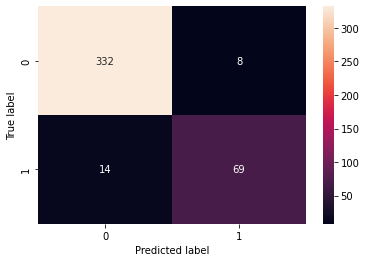

In [69]:
actual = predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()

print('Accuracy score of predicted data :',accuracy_score(actual, predicted))

# precision score
print('Precision Score of predicted data :',precision_score(actual, predicted))

# recall score
print('Recall Score of predicted data :',recall_score(actual, predicted))

# F1 score
print('F1 Score of predicted data :',f1_score(actual, predicted))

cf_matrix = confusion_matrix(actual, predicted)
sn.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Proposed Ways

In [70]:
predictions_modified = make_predictions_based_on_modifications(df, pipelineModel, model)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1173|
|       1.0|  228|
+----------+-----+



# Insertion to DB

In [71]:
driver = 'com.mysql.jdbc.Driver'
insert_to_mysql(feature_importance_df, predictions_modified, HOST, DB_NAME, DB_USER, DB_PASS, driver)

True